In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
cwd = os.getcwd()

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10 
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=cwd + '/data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=cwd + '/data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)



Input image
torch.Size([1, 28, 28])


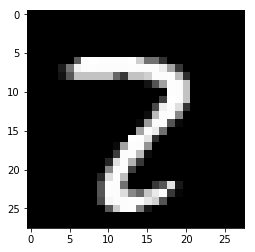

In [3]:
# Visualize example input image
train_iter = iter(train_loader)
images, labels = train_iter.next()

img = images[0]
fig, ax = plt.subplots()
ax.imshow(img.data.numpy().reshape((28,28)), cmap = plt.cm.gray)
print('Input image')
print(img.shape) # 1 channel, WxH = 28x28
plt.show()

In [4]:
# Convolutional neural network (2 convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        '''
        Convolution layer 1
        Input: 1x28x28
        Output: 16x14x14
        '''
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        '''
        Convolution layer 2
        Input: 16x14x14
        Output: 32x7x7
        '''
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully Connected
        self.fc = nn.Linear(32*7*7, num_classes)
        
        #self.softmax = nn.Softmax()
        
    def Flatten(self, x):
        x = x.view(x.size(0), -1)
        return x
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.Flatten(out)
        out = self.fc(out)
        #out = self.softmax(out) ####SOFTMAX IS INCLUDED IN CrossEntropyLoss in Pytorch
        return out

In [5]:
# Instantiate net
model = ConvNet(num_classes).to(device)

In [6]:
## Trainining Pipeline

# Loss and Optimizer
criterion = nn.CrossEntropyLoss() #Includes softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward Pass
        optimizer.zero_grad() # Clear stored gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Calculate error
        
        #Backward and optimize
        loss.backward() # Compute gradients
        optimizer.step() # Update weights
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.4423
Epoch [1/5], Step [200/600], Loss: 0.1144
Epoch [1/5], Step [300/600], Loss: 0.0931
Epoch [1/5], Step [400/600], Loss: 0.1329
Epoch [1/5], Step [500/600], Loss: 0.1058
Epoch [1/5], Step [600/600], Loss: 0.0854
Epoch [2/5], Step [100/600], Loss: 0.1881
Epoch [2/5], Step [200/600], Loss: 0.0446
Epoch [2/5], Step [300/600], Loss: 0.0164
Epoch [2/5], Step [400/600], Loss: 0.0710
Epoch [2/5], Step [500/600], Loss: 0.1115
Epoch [2/5], Step [600/600], Loss: 0.0420
Epoch [3/5], Step [100/600], Loss: 0.0765
Epoch [3/5], Step [200/600], Loss: 0.0280
Epoch [3/5], Step [300/600], Loss: 0.0706
Epoch [3/5], Step [400/600], Loss: 0.0488
Epoch [3/5], Step [500/600], Loss: 0.0169
Epoch [3/5], Step [600/600], Loss: 0.0897
Epoch [4/5], Step [100/600], Loss: 0.0392
Epoch [4/5], Step [200/600], Loss: 0.0111
Epoch [4/5], Step [300/600], Loss: 0.0186
Epoch [4/5], Step [400/600], Loss: 0.0516
Epoch [4/5], Step [500/600], Loss: 0.0916
Epoch [4/5], Step [600/600], Loss:

In [8]:
modelFilename = 'mnist-cnn.model'

# Save the Trained Model
if not os.path.exists(modelFilename):
    torch.save(model.state_dict(), modelFilename)

In [9]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 98.94 %
